In [1]:
from reservoir import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Load sample data

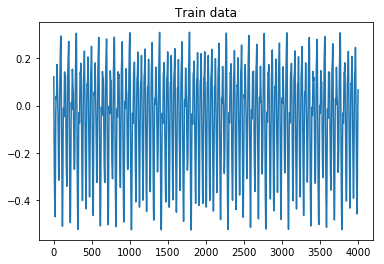

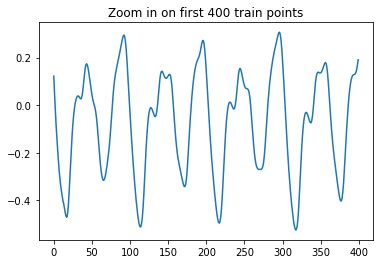

In [2]:
data = np.loadtxt('../Datasets/MackeyGlass_t17.txt')

train = data[:4000].reshape(-1, 1)
test = data[4000:6000].reshape(-1, 1)
plt.title("Train data")
plt.plot(train)
plt.show()
plt.title("Zoom in on first 400 train points")
plt.plot(train[:400])
plt.show()

### Add noise

In [ ]:
# Define noisy data for Bayesian Optimization
snr = 4
noise_std = np.sqrt(train.std(ddof=1)**2 / snr)

print('Standard deviation of noise is:', noise_std)
noisy_train = train + np.random.normal(0, noise_std, size=train.shape)
noisy_test = test + np.random.normal(0, noise_std, size=test.shape)
plt.plot(noisy_train[:400])
plt.show()

### Combine multiple series for evaluation if desired

In [ ]:
multiple_train = np.hstack((train, noisy_train))
multiple_test = np.hstack((test, noisy_test))

### Set bounds

In [ ]:
bounds = [
    {'name': 'input_scaling', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'feedback_scaling', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'leaking_rate', 'type': 'continuous', 'domain': (0, 1)}, 
    {'name': 'spectral_radius', 'type': 'continuous', 'domain': (0, 1.25)},
    {'name': 'regularization', 'type': 'continuous', 'domain': (-12, 1)},
    {'name': 'connectivity', 'type': 'continuous', 'domain': (-3, 0)},
    {'name': 'n_nodes', 'type': 'continuous', 'domain': (100, 1500)}
]

### Optimize

In [ ]:
# Set optimization parameters
esn_cv = EchoStateNetworkCV(bounds=bounds,
                            initial_samples=200,
                            subsequence_length=1000,
                            eps=1e-8,
                            cv_samples=1, 
                            max_iterations=100, 
                            scoring_method='tanh',
                            verbose=True)

In [ ]:
# Optimize (this may take a while!)
best_arguments = esn_cv.optimize(y=multiple_train)

In [ ]:
# Train best model(s)
esn = EchoStateNetwork(**best_arguments)
esn.train(y=train)

esn2 = EchoStateNetwork(**best_arguments)
esn2.train(y=noisy_train)

In [ ]:
# Test
score = esn.test(y=test, scoring_method='rmse')
score2 = esn.test(y=noisy_test, scoring_method='rmse')
print(score)
print(score2)

### Inspect performance

In [ ]:
# Diagnostic plots
plt.plot(esn.predict(100), label='Predicted')
plt.plot(test[:100], label='Ground truth')
plt.title('Prediction on next 100 steps')
plt.legend()
plt.show()

plt.plot(esn2.predict(100), label='Predicted')
plt.plot(noisy_test[:100], label='Ground truth')
plt.title('Prediction on next 100 steps')
plt.legend()
plt.show()

## Manually tuned example, for comparison

In [3]:
# Regular approach
esn = EchoStateNetwork(n_nodes=1000, connectivity=0.01, input_scaling=0.5, feedback_scaling=0.5, leaking_rate=0.3, 
                       spectral_radius=1.25, regularization=1e-8, feedback=True)
complete_data, y_used, burn_in = esn.train(y=train, burn_in=100)

0.0017928983258260376

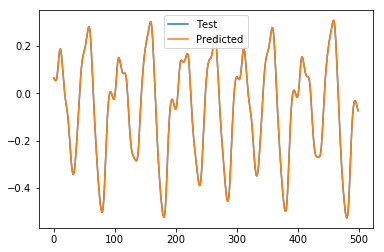

In [4]:
# Prediction sample for ground truth
plt.plot(test[:500], label='Test')
plt.plot(esn.predict(500), label='Predicted')
plt.legend()
esn.test(y=test[:500], scoring_method='nrmse')

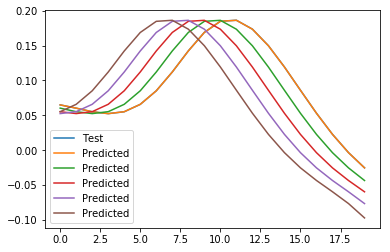

In [5]:
# Stepwise prediction
five_step_prediction = esn.predict_stepwise(test[:20], steps_ahead=5)
plt.plot(test[:20], label='Test')
plt.plot(five_step_prediction, label='Predicted')
plt.legend();

In [6]:
five_step_prediction

array([[ 0.06493773,  0.06028643,  0.05514944,  0.05244896,  0.05516537],
       [ 0.06026175,  0.05513779,  0.05245839,  0.05519341,  0.06573726],
       [ 0.0551073 ,  0.05244356,  0.05520485,  0.06577206,  0.08514228],
       [ 0.05240665,  0.05518741,  0.06578684,  0.08518458,  0.11209123],
       [ 0.05513988,  0.06576591,  0.0852057 ,  0.1121455 ,  0.1422961 ],
       [ 0.06571724,  0.08518675,  0.11217036,  0.14235145,  0.16888892],
       [ 0.08516048,  0.11216215,  0.14236743,  0.16891895,  0.18489174],
       [ 0.1121587 ,  0.14236672,  0.16892147,  0.18489573,  0.18638434],
       [ 0.14237198,  0.16892194,  0.18489122,  0.1863782 ,  0.17364481],
       [ 0.16894555,  0.18489084,  0.18635576,  0.17361748,  0.14988644],
       [ 0.18493632,  0.186352  ,  0.17357224,  0.14983519,  0.11934909],
       [ 0.18639413,  0.17356753,  0.14979292,  0.11930272,  0.08599682],
       [ 0.17360456,  0.14978832,  0.11926532,  0.08595577,  0.05299906],
       [ 0.14983718,  0.11925892,  0.0